In [1]:
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
import peakutils

from get_12ECG_features import get_12ECG_features,get_fft_peaks, bandpass_filter, findpeaks, get_diagnosis
from driver import load_challenge_data, get_classes

import warnings
warnings.filterwarnings('ignore')

In [136]:
!wget -O PhysioNetChallenge2020_Training_CPSC.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/

--2020-06-19 10:45:09--  https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/
Resolving cloudypipeline.com (cloudypipeline.com)... 34.74.104.185
Connecting to cloudypipeline.com (cloudypipeline.com)|34.74.104.185|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 859952525 (820M) [application/octet-stream]
Saving to: ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’

PhysioNetChallenge2 100%[===================>] 820.11M  33.0MB/s    in 29s     

2020-06-19 10:45:38 (28.3 MB/s) - ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’ saved [859952525/859952525]



In [137]:
my_tar = tarfile.open('PhysioNetChallenge2020_Training_CPSC.tar.gz')
my_tar.extractall('./data') # specify which folder to extract to
my_tar.close()

In [2]:
input_files = []
input_directory = 'data/Training_WFDB/'

# Append all files in a list
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
           input_files.append(f)

In [3]:
#Create a dictionary with classes, for visual purposes and undertand better the diagnosis
classes = get_classes(input_directory, input_files );
classes_dict = dict(zip(classes, ['PVC', 'AF', 'LBBB', 'STE' , 'IAVB', 'PAC', 'Normal', 'STD', 'RBBB' ]))
classes_dict

{'164884008': 'PVC',
 '164889003': 'AF',
 '164909002': 'LBBB',
 '164931005': 'STE',
 '270492004': 'IAVB',
 '284470004': 'PAC',
 '426783006': 'Normal',
 '429622005': 'STD',
 '59118001': 'RBBB'}

R peak values:  [ 883.77225259  986.65440534 1099.02310163 1188.72873175  932.00115151
  978.11921922 1140.9672651  1157.39716393 1150.75916885  914.53997724
 1032.9464409  1127.66366968 1123.51658217  861.53086202 1054.70588243
 1181.07846295 1137.96640164 1077.64297655]
R peak index:  [ 118  431  733 1050 1368 1685 1989 2302 2616 2937 3244 3557 3869 4190
 4501 4811 5127 5445]


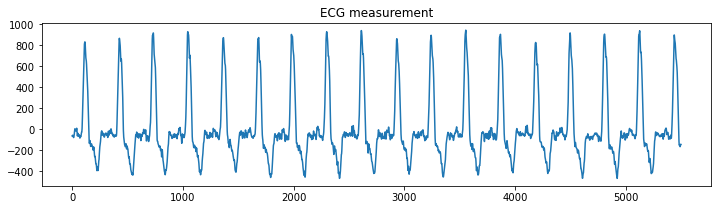

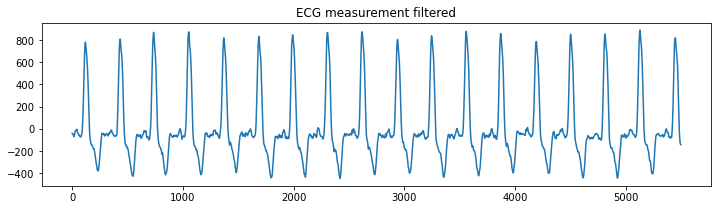

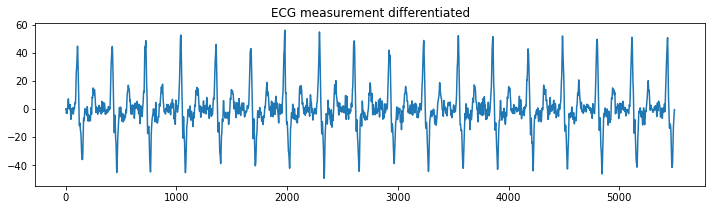

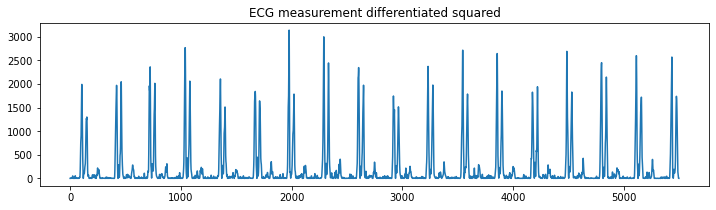

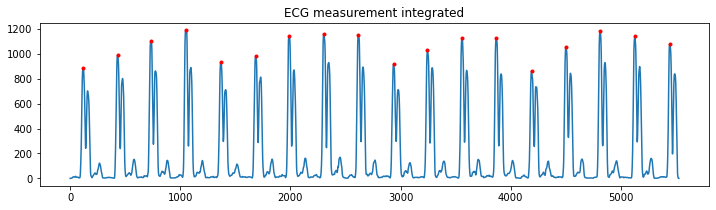

In [4]:
# Just for visualization purposes and better understand the feature extraction, I will
# plot the different signal processing steps to obtain the R peak information

tmp_input_file = os.path.join(input_directory, input_files[2])
data, header_data = load_challenge_data(tmp_input_file)

tmp_hea = header_data[0].split(' ')
num_leads = int(tmp_hea[1])
sample_Fs= int(tmp_hea[2])
gain_lead = np.zeros(num_leads)

for ii in range(num_leads):
    tmp_hea = header_data[ii+1].split(' ')
    gain_lead[ii] = int(tmp_hea[2].split('/')[0])
    
#   We are only using data from lead1
ecg_measurements,signal_frequency,gain = data[0],sample_Fs,gain_lead[0]

plt.figure(figsize=(12,3))
plt.plot(range(len(ecg_measurements)), ecg_measurements)
plt.title('ECG measurement')

#Parameters to isolate R peaks
filter_lowcut = 0.001
filter_highcut = 15.0
filter_order = 1
integration_window = 30  # Change proportionally when adjusting frequency (in samples).
findpeaks_limit = 100
findpeaks_spacing = 100  # Change proportionally when adjusting frequency (in samples).


# Measurements filtering - 0-15 Hz band pass filter.
filtered_ecg_measurements = bandpass_filter(ecg_measurements, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=signal_frequency, filter_order=filter_order)

filtered_ecg_measurements[:5] = filtered_ecg_measurements[5]
plt.figure(figsize=(12,3))
plt.plot(range(len(filtered_ecg_measurements)), filtered_ecg_measurements)
plt.title('ECG measurement filtered')


# Derivative - provides QRS slope information.
differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)
plt.figure(figsize=(12,3))
plt.plot(range(len(differentiated_ecg_measurements)), differentiated_ecg_measurements)
plt.title('ECG measurement differentiated')


# Squaring - intensifies values received in derivative.
squared_ecg_measurements = differentiated_ecg_measurements ** 2
plt.figure(figsize=(12,3))
plt.plot(range(len(squared_ecg_measurements)), squared_ecg_measurements)
plt.title('ECG measurement differentiated squared')


# Moving-window integration.
integrated_ecg_measurements_R = np.convolve(squared_ecg_measurements, np.ones(integration_window)/integration_window)


detected_peaks_indices_R = findpeaks(data=integrated_ecg_measurements_R,
                                             limit=findpeaks_limit,
                                             spacing=findpeaks_spacing)

detected_R_peak_values = integrated_ecg_measurements_R[detected_peaks_indices_R]

plt.figure(figsize=(12,3))
plt.plot(range(len(integrated_ecg_measurements_R)), integrated_ecg_measurements_R);
plt.plot(detected_peaks_indices_R, integrated_ecg_measurements_R[detected_peaks_indices_R], 'r.')
plt.title('ECG measurement integrated')

print ('R peak values: ',detected_R_peak_values)
print('R peak index: ',detected_peaks_indices_R)

[18, 35, 53, 70, 88]
[154109.89233540176, 261173.50615644827, 363953.3802377119, 533296.2291858464, 684781.038441112]
[18, 35, 53, 70]


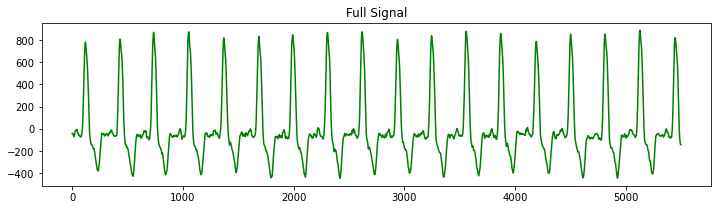

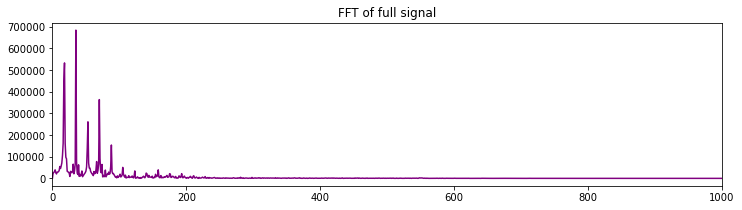

In [5]:
# For the FFT, I take the bandpassed filtered ecg signal from the previous step
full_signal_fft_values = np.abs(fft(filtered_ecg_measurements))
x_values_fft = range(0, len(filtered_ecg_measurements), 1)

peaks_ind = peakutils.indexes(full_signal_fft_values, thres=0.2, min_dist=5)
peaks_ind = [peak for peak in peaks_ind if peak < 1000]
print(peaks_ind)

sorted_amplitudes = sorted(full_signal_fft_values[peaks_ind])
four_highest_peaks = [peak for peak in peaks_ind if (full_signal_fft_values[peak] in sorted_amplitudes)][:4]
print(sorted_amplitudes)
print(four_highest_peaks)

plt.figure(figsize=(12,3))
plt.plot(x_values_fft, filtered_ecg_measurements, color = 'green')
plt.title('Full Signal')

plt.figure(figsize=(12,3))
plt.plot(x_values_fft, list(full_signal_fft_values), color = 'purple')
plt.xlim([0,1000])
plt.title('FFT of full signal');

In [7]:
# Load all data in a data frame with the diagnosis as the target column.
# I changed a little bit the feature extraction of the function get_12ECG_features, 
# it now takes into accout lead 1 of the ECG and makes calculations regarding the RR parameter,
# in amplitude and time difference between peaks. 

# Also, a simple FFT analysis for each lead 1 is done. The four highest FFT peaks are stored as features in the 
# data frame.This frequency information might add relevant information for the different arrythmias.

# To evaluate RR characteristics, taking into account only lead one, might be sufficient. 
# However, feature extraction could be improved by detecting other ECG relevant parameters, such as PR time, 
# ST time or width of the QRS complex. Taking into account these paramenters would improve the machine learning 
# model and predictions. 

# Note that RR information or the FFT peaks are not meaningful for some of the targeted arrythmias.

df = pd.DataFrame(columns = ['age','sex','mean_RR_ms','mean_Peaks','median_RR_ms','median_Peaks',
                             'std_RR_ms','std_Peaks','skew_RR_ms','skew_Peaks',
                             'kurt_RR_ms','kurt_Peaks','first_fft_peak', 'second_fft_peak','third_fft_peak',
                             'forth_fft_peak', 'target'])

for i,f in enumerate(input_files):
    tmp_input_file = os.path.join(input_directory, f)
    data, header_data = load_challenge_data(tmp_input_file)
    
    #These features are only the ones related to lead 1
    features=list(get_12ECG_features(data, header_data))
    
    fft_peaks = get_fft_peaks(data,header_data)
   
    # Append the fft four highest peaks to the features
    [features.append(fft_peak) for fft_peak in fft_peaks]
    
    target = (get_diagnosis(header_data))
    features.append(classes_dict[target])
    df.loc[i] = (features)

In [8]:
df.head()

,age,sex,mean_RR_ms,mean_Peaks,median_RR_ms,median_Peaks,std_RR_ms,std_Peaks,skew_RR_ms,skew_Peaks,kurt_RR_ms,kurt_Peaks,first_fft_peak,second_fft_peak,third_fft_peak,forth_fft_peak,target
0,76.0,1.0,489.187500,2.149689e+05,406.0,2.482889e+05,222.293083,2.256133e+05,0.735385,2.630562,-0.622879,9.783462,6,14,23,29,STD
1,32.0,1.0,392.480000,1.046937e+06,294.0,8.038087e+04,125.634747,1.084130e+06,0.309378,0.286475,-1.794191,-1.759897,12,24,36,48,Normal
2,65.0,1.0,626.705882,1.057167e+06,626.0,1.088333e+06,10.514778,1.034741e+05,-0.558734,-0.530312,-0.364476,-1.088446,18,35,53,70,LBBB
3,44.0,0.0,772.827586,1.475160e+06,864.0,1.646322e+06,200.641397,5.846316e+05,-1.475323,-1.978140,0.603296,2.253281,26,52,78,104,STE
4,75.0,0.0,612.666667,1.378173e+06,547.0,1.948875e+06,213.954305,9.311654e+05,0.073490,-0.776518,-1.601420,-1.373767,13,26,40,53,IAVB


In [9]:
#Factorize categorical target for modeling
df['target'], label = pd.factorize(df['target'])

In [10]:
df.head()

,age,sex,mean_RR_ms,mean_Peaks,median_RR_ms,median_Peaks,std_RR_ms,std_Peaks,skew_RR_ms,skew_Peaks,kurt_RR_ms,kurt_Peaks,first_fft_peak,second_fft_peak,third_fft_peak,forth_fft_peak,target
0,76.0,1.0,489.187500,2.149689e+05,406.0,2.482889e+05,222.293083,2.256133e+05,0.735385,2.630562,-0.622879,9.783462,6,14,23,29,0
1,32.0,1.0,392.480000,1.046937e+06,294.0,8.038087e+04,125.634747,1.084130e+06,0.309378,0.286475,-1.794191,-1.759897,12,24,36,48,1
2,65.0,1.0,626.705882,1.057167e+06,626.0,1.088333e+06,10.514778,1.034741e+05,-0.558734,-0.530312,-0.364476,-1.088446,18,35,53,70,2
3,44.0,0.0,772.827586,1.475160e+06,864.0,1.646322e+06,200.641397,5.846316e+05,-1.475323,-1.978140,0.603296,2.253281,26,52,78,104,3
4,75.0,0.0,612.666667,1.378173e+06,547.0,1.948875e+06,213.954305,9.311654e+05,0.073490,-0.776518,-1.601420,-1.373767,13,26,40,53,4


In [11]:
label

Index(['STD', 'Normal', 'LBBB', 'STE', 'IAVB', 'RBBB', 'AF', 'PAC', 'PVC'], dtype='object')

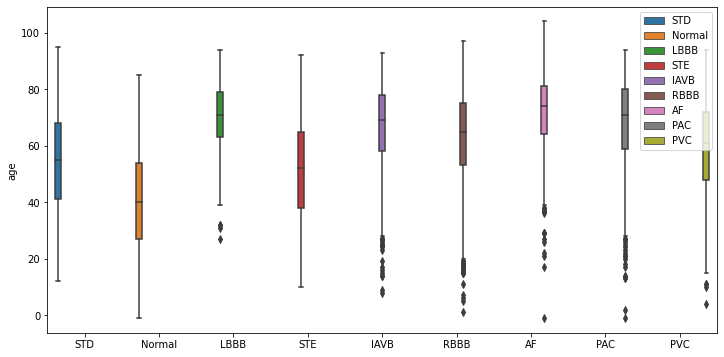

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=label[df['target']], y=df['age'], hue=label[df['target']]);
plt.legend(loc='upper right');

We see that some arrythmias such as 1st degree AV block (IAVB), right bundle brach block (RBBB), premature atrial contraction (PAC) or atrial fibrilation (AF) are more common at ages higher than 60. However, they also have a lot of outliers, meaning there are very young patients suffering from these cardiac pathologies.

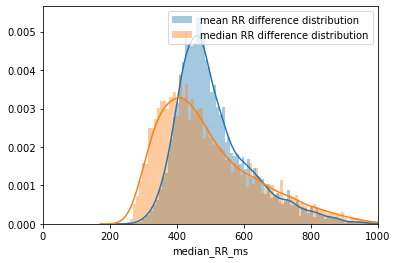

In [13]:
# Let us better understand the data by plotting some distributions 
sns.distplot(df['mean_RR_ms'],bins=100, label='mean RR difference distribution');
sns.distplot(df['median_RR_ms'],bins=100, label='median RR difference distribution');
plt.xlim([0,1000])
plt.legend();

Mean and median are not very close, meaning we do not have a symmetric distribution. It is actually a right skewed distribution.

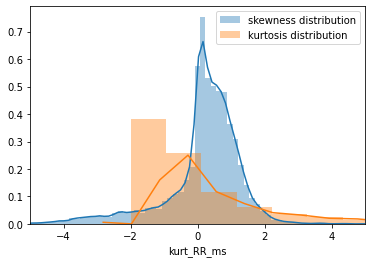

In [14]:
sns.distplot(df['skew_RR_ms'],bins=100, label='skewness distribution');
sns.distplot(df['kurt_RR_ms'],bins=100, label='kurtosis distribution');
plt.xlim([-5,5])

plt.legend();

From these plots we confirm what we saw in the previous "RR time difference" distributions. There is a slightly right skewed distribution. In addition, there is a negative kurtosis, around -0.25, meaning the tails of the distribution decrease quickly.

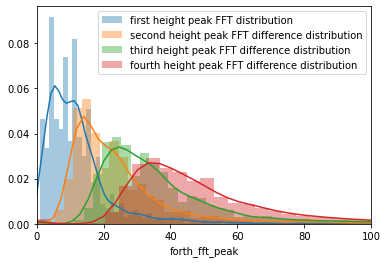

In [15]:
# Let us better understand the data by plotting some distributions 
sns.distplot(df['first_fft_peak'],bins=100, label='first height peak FFT distribution');
sns.distplot(df['second_fft_peak'],bins=100, label='second height peak FFT difference distribution');
sns.distplot(df['third_fft_peak'],bins=100, label='third height peak FFT difference distribution');
sns.distplot(df['forth_fft_peak'],bins=100, label='fourth height peak FFT difference distribution');
plt.xlim([0,100])
plt.legend();

We observe the distribution of the four main frequencies in our ECG lead 1. This might add meaningful information
for the modeling

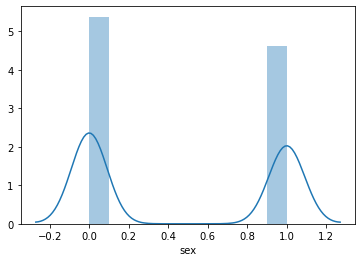

In [16]:
# confirmation that sex distribution is quite balanced in all observations
sns.distplot(df['sex'], norm_hist=True);

## Let us start modeling the classification problem


In [17]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [18]:
# Create target object and call it y
y = df['target']
# Create X
X = df.loc[:, df.columns != 'target']

#Scale the feature data before spliting
scaler = StandardScaler()
X_scaled = pd.DataFrame(data= scaler.fit_transform(X), columns=X.columns)

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

#Create a data frame which will store all the model scores
model_score = pd.DataFrame(index = ['Model Score','Model'])

As a metric, I will optimize the accuracy of the model and will create a classification report.
After that, using cross validation I will get the score of the optimized model.

In the challenge, other metrics are defined, I run these evaluation at the end, after saving the model

# Decision tree classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
tree_model = DecisionTreeClassifier(random_state=1)
# Fit Model
tree_model.fit(train_X, train_y)

# Make validation predictions and calculate accuracy for default model
predictions = tree_model.predict(test_X)
acc = accuracy_score(predictions, test_y)
print("Prediction accuracy for Decision Tree: {:,.3f}".format(acc))

Prediction accuracy for Decision Tree: 0.358


In [20]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : np.arange(10,200,10),
              "max_depth": np.arange(1, 10),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": np.arange(1, 9),
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=1, scoring='accuracy')

# Fit it to the data
tree_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 2, 'max_leaf_nodes': 120, 'max_features': 8, 'max_depth': 8, 'criterion': 'entropy'}
Best score is 0.3786570885971431


In [21]:
best_dt = tree_cv.best_estimator_.fit(train_X, train_y)

predictions = best_dt.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.38      0.21      0.27       176
           1       0.45      0.61      0.52       181
           2       0.22      0.15      0.18        48
           3       0.00      0.00      0.00        33
           4       0.22      0.14      0.17       142
           5       0.36      0.50      0.42       338
           6       0.48      0.66      0.55       201
           7       0.14      0.07      0.09       131
           8       0.24      0.17      0.20       126

    accuracy                           0.37      1376
   macro avg       0.28      0.28      0.27      1376
weighted avg       0.33      0.37      0.34      1376



In [22]:
score = cross_val_score(best_dt, X_scaled, y, cv=5).mean()
score

0.37952441860465114

In [23]:
model_score['DecisionTree'] =  [score, best_dt]

# Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the accuracy of your Random Forest model 
predict_y=rf_model.predict(test_X)
rf_acc = accuracy_score(test_y,predict_y)

print("Prediction accuracy for Random Forest Model: {}".format(rf_acc))

Prediction accuracy for Random Forest Model: 0.470203488372093


In [25]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions 
param_dist = {"max_leaf_nodes" : np.arange(2,300,50),
              "max_depth": np.arange(10, 40,10),
              "max_features": np.arange(1, 9,2)}

# Create the RandomizedSearchCV object
forest_cv = RandomizedSearchCV(rf_model, param_dist, cv=5, random_state=1, scoring='accuracy')

# Fit it to the data
forest_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Forest Parameters: {'max_leaf_nodes': 252, 'max_features': 3, 'max_depth': 30}
Best score is 0.44700817438692103


In [26]:
best_fr = forest_cv.best_estimator_.fit(train_X, train_y)

predictions = best_fr.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38       176
           1       0.50      0.63      0.56       181
           2       1.00      0.04      0.08        48
           3       0.00      0.00      0.00        33
           4       0.35      0.08      0.14       142
           5       0.38      0.71      0.50       338
           6       0.53      0.75      0.62       201
           7       0.60      0.07      0.12       131
           8       0.51      0.26      0.35       126

    accuracy                           0.45      1376
   macro avg       0.48      0.32      0.31      1376
weighted avg       0.47      0.45      0.40      1376



In [27]:
# Save the mean of the cross validation score
score = cross_val_score(best_fr,X_scaled, y, cv=3).mean()
score

0.4497586934664953

In [28]:
model_score['RandomForest'] =  [score, best_fr]

# K-Neighbors model

In [29]:
# Instantiate and fit a k-NN classifier to the unscaled data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, train_y)


KNeighborsClassifier(n_neighbors=3)

In [30]:
predict_y=knn.predict(test_X)
acc = accuracy_score(test_y,predict_y)

print("Prediction accuracy for Knn model: {}".format(acc))

Prediction accuracy for Knn model: 0.3502906976744186


In [31]:
#Let us use Randomized Grid search to optimize number of neighbors hyperparameters

# Setup the parameters and distributions 
param_dist = {"n_neighbors" : np.arange(1,10)}

# Create the RandomizedSearchCV object, scoring the recall
knn_cv = RandomizedSearchCV(knn, param_dist, cv=5, random_state=1, scoring='accuracy')

# Fit it to the data
knn_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned Forest Parameters: {'n_neighbors': 9}
Best score is 0.3790202295433903


In [32]:
best_knn = knn_cv.best_estimator_.fit(train_X, train_y)

predictions = best_knn.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.32      0.39      0.35       176
           1       0.43      0.61      0.50       181
           2       0.38      0.10      0.16        48
           3       0.06      0.03      0.04        33
           4       0.17      0.12      0.14       142
           5       0.38      0.52      0.44       338
           6       0.54      0.58      0.56       201
           7       0.22      0.06      0.10       131
           8       0.36      0.17      0.23       126

    accuracy                           0.38      1376
   macro avg       0.32      0.29      0.28      1376
weighted avg       0.36      0.38      0.35      1376



In [33]:
score = cross_val_score(best_knn, X_scaled, y, cv=5).mean()
score

0.3801095137420719

In [34]:
model_score['K-neighbors'] =  [score, best_knn]

# XGBoost

In [35]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbModel = XGBClassifier()
xgbModel.fit(train_X,train_y)

XGBClassifier(objective='multi:softprob')

In [36]:
#Do a simple precition before tuning the model to see the accuracy
predictions = xgbModel.predict(test_X)
acc = accuracy_score(predictions, test_y)
print("Prediction accuracy for XGBoost: {:,.3f}".format(acc))

Prediction accuracy for XGBoost: 0.432


In [37]:
#We have explored the data and got the test prediction error. Let us now tune the model to improve the performance
#tuning the hyperparameters

gbm_param_grid = {
    'n_estimators': np.arange(10,1000,200),
    'max_depth': range(2, 10),
    'learning_rate': np.arange(0.1,0.5,0.1)
}

# Perform random search of hyperparameteres
r_xgb = RandomizedSearchCV(estimator=xgbModel, param_distributions=gbm_param_grid, cv=3, 
                                    n_iter=5, verbose=1, random_state=42, n_jobs=-1, scoring='accuracy')

# Fit best_xgb to the data
r_xgb.fit(train_X,train_y)

# Print the best parameters
print("Best parameters found: ", r_xgb.best_params_)
print("Highest score: ", (r_xgb.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


Best parameters found:  {'n_estimators': 610, 'max_depth': 7, 'learning_rate': 0.30000000000000004}
Highest score:  0.4568265906580021


In [38]:
best_xgb = r_xgb.best_estimator_.fit(train_X, train_y)

predictions = best_xgb.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.43      0.44      0.44       176
           1       0.52      0.59      0.56       181
           2       0.54      0.27      0.36        48
           3       0.50      0.30      0.38        33
           4       0.24      0.16      0.19       142
           5       0.46      0.61      0.52       338
           6       0.66      0.73      0.69       201
           7       0.31      0.17      0.22       131
           8       0.46      0.42      0.44       126

    accuracy                           0.48      1376
   macro avg       0.46      0.41      0.42      1376
weighted avg       0.46      0.48      0.46      1376



In [39]:
score = cross_val_score(best_xgb, X_scaled, y, cv=5).mean()
score

0.48523837209302323

In [40]:
model_score['XGBBoost'] =  [score, best_xgb]

In [41]:
final_scores = pd.DataFrame(model_score).transpose()
final_scores.sort_values(by='Model Score' ,ascending=False, inplace=True)
final_scores

,Model Score,Model
XGBBoost,0.485238,XGBClassifier(learning_rate=0.3000000000000000...
RandomForest,0.449759,"(DecisionTreeClassifier(max_depth=30, max_feat..."
K-neighbors,0.38011,KNeighborsClassifier(n_neighbors=9)
DecisionTree,0.379524,"DecisionTreeClassifier(criterion='entropy', ma..."


As we can see, the trained model performance is not very accurate. It is not surprising since we do not have a detailed data feature extraction. As I mentioned before, taking into account only R peak characteristics or some FFT properties of the ECG to detect arrythmias is not enough.
In the dataframe features we should include information about P, QRS, T waves, time between waves, amplitude, etc. Extracting these features if quite complicated, considering the variability in morphology of all the ECG signals in the dataset. This is out of the scope of this first approach project. 

Just as an example, arrythmias such as atrial fibrilation are strongly related to the P wave a not realted to the R peaks of the ECG, and we have not included this information in the model. Therefore, the model does not learn about these features and does not detect this arrythmia accurately.

In [43]:
# RandomForest classifier has a bit lower performance than XGBoost, however, I have decided to take 
# the Randomforest, because it trains and runs faster, in case it needs to be retrained.
best_model = final_scores['Model']['RandomForest']

In [44]:
# I save the model with the scaling step in a pipeline
steps = [('scaler', StandardScaler()),
        ('model', best_model)]
        
# Create the pipeline
pipeline = Pipeline(steps)
pipeline.fit(train_X,train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=30, max_features=3,
                                        max_leaf_nodes=252, random_state=1))])

In [45]:
# Save the best model for further predictions
import pickle
pickle.dump(pipeline,open("classifier.model","wb"))

In [46]:
# Execute driver.py using the saved classifier.model.
# The first argument is the data input folder and the second argument is the folder where we save the predictions.
!python driver.py ./data/Training_WFDB/ output

Loading 12ECG model...
Extracting 12ECG features...
Done.


In [126]:
# evaluate the output from your algorithm using multiple evaluation metrics that are described 
# on the webpage for the PhysioNet/CinC Challenge 2020.
!python evaluate_12ECG_score.py data/Training_WFDB/ output

AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure
0.530|0.129|0.795|0.029|0.043|0.013


In [134]:
#Create requirements file for installing all packages
!pip freeze > requirements.txt